# Morphological Complexity and Semantic Organization: Stage 1 Baseline Analysis

This notebook establishes foundational measurements to validate our computational approach to morphological complexity and build baseline semantic networks. We test whether our measures successfully capture the theoretical complexity gradient: **English** < **Russian** < **Turkish**.

Our analysis follows **Ackerman & Malouf's (2013)** framework distinguishing **E-complexity** (paradigm size) from **I-complexity** (morphological predictability). Stage 1 uses surface-level proxies to confirm that computational measures align with theoretical expectations before advancing to sophisticated analysis in Stage 2.

> The goal of this stage is to test our complexity gradient **English** < **Russian** < **Turkish** with simple morphological and semantic metrics.

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import networkx as nx
import json
from collections import Counter
import re
import pickle
from tqdm.notebook import tqdm

plt.style.use("seaborn-v0_8-whitegrid")

In [19]:
CORPORA = {
    "English": Path("../data/processed/clean_text/english_clean.txt"),
    "Russian": Path("../data/processed/clean_text/russian_clean.txt"),
    "Turkish": Path("../data/processed/clean_text/turkish_clean.txt"),
}
KEEP_FOR_PLOTS = 1000

In [1]:
stats = {}
for lang, path in CORPORA.items():
    total_tokens = total_chars = n_articles = 0
    tokens_per_article, chars_per_article, buf = [], [], []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if not s:
                if buf:
                    text = " ".join(buf)
                    t_cnt, c_cnt = len(text.split()), len(text)
                    total_tokens += t_cnt; total_chars += c_cnt; n_articles += 1
                    if len(tokens_per_article) < KEEP_FOR_PLOTS:
                        tokens_per_article.append(t_cnt); chars_per_article.append(c_cnt)
                    buf = []
            else:
                buf.append(s)
        if buf:
            text = " ".join(buf)
            t_cnt, c_cnt = len(text.split()), len(text)
            total_tokens += t_cnt; total_chars += c_cnt; n_articles += 1
            if len(tokens_per_article) < KEEP_FOR_PLOTS:
                tokens_per_article.append(t_cnt); chars_per_article.append(c_cnt)

    s = {
        "n_articles": n_articles,
        "total_tokens": total_tokens,
        "total_chars": total_chars,
        "mean_tokens_per_article": float(np.mean(tokens_per_article)) if tokens_per_article else 0.0,
        "std_tokens_per_article": float(np.std(tokens_per_article)) if tokens_per_article else 0.0,
        "median_tokens_per_article": float(np.median(tokens_per_article)) if tokens_per_article else 0.0,
        "mean_chars_per_token": (total_chars / total_tokens) if total_tokens else 0.0,
        "tokens_per_article": tokens_per_article,
        "chars_per_article": chars_per_article,
    }
    stats[lang] = s
    print(f"Articles:       {s['n_articles']:,}")
    print(f"Total tokens:   {s['total_tokens']:,}")
    print(f"Tokens/article: {s['mean_tokens_per_article']:.1f} ± {s['std_tokens_per_article']:.1f} "
          f"(median {s['median_tokens_per_article']:.1f})")
    print(f"Chars/token:    {s['mean_chars_per_token']:.2f}")


English
Articles:       350,000
Total tokens:   368,910,801
Tokens/article: 2202.6 ± 2113.1 (median 1544.5)
Chars/token:    6.13

Russian
Articles:       349,988
Total tokens:   163,742,644
Tokens/article: 1532.3 ± 2003.9 (median 829.0)
Chars/token:    7.07

Turkish
Articles:       349,969
Total tokens:   75,577,889
Tokens/article: 614.5 ± 1028.9 (median 260.5)
Chars/token:    7.20


## Establishing the Morphological Complexity Gradient

Our first task is confirming that our three target languages exhibit the expected complexity differences. We analyze comparable corpora of approximately 350,000 articles each, extracted from Wikipedia to ensure domain consistency. 

The key challenge here is **token imbalance**. We can see that our corpora contain vastly different token counts (English: 369M, Russian: 164M, Turkish: 76M, which we must address before further analysis.

In [5]:
summary_df = pd.DataFrame({
    lang: {k: v for k, v in s.items() if not isinstance(v, list)}
    for lang, s in stats.items()
}).T
summary_df

,n_articles,total_tokens,total_chars,mean_tokens_per_article,std_tokens_per_article,median_tokens_per_article,mean_chars_per_token
English,350000.0,368910801.0,2.260091e+09,2202.611,2113.142347,1544.5,6.126389
Russian,349988.0,163742644.0,1.157657e+09,1532.270,2003.942514,829.0,7.069980
Turkish,349969.0,75577889.0,5.440182e+08,614.501,1028.868752,260.5,7.198114


In [10]:
PHASE1_DIR = Path("../results/phase1")
PHASE1_DIR.mkdir(parents=True, exist_ok=True)
summary_df.to_csv(PHASE1_DIR / "summary_corpus_stats.csv", index=True)

With this statistics we can see that the average word length also follows a pattern: English 6.13 < Russian 7.07 < Turkish 7.20. 

> This matches what we expect from the complexity line we want to test: English $\rightarrow$ Russian $\rightarrow$ Turkish

# Plotting the distributions

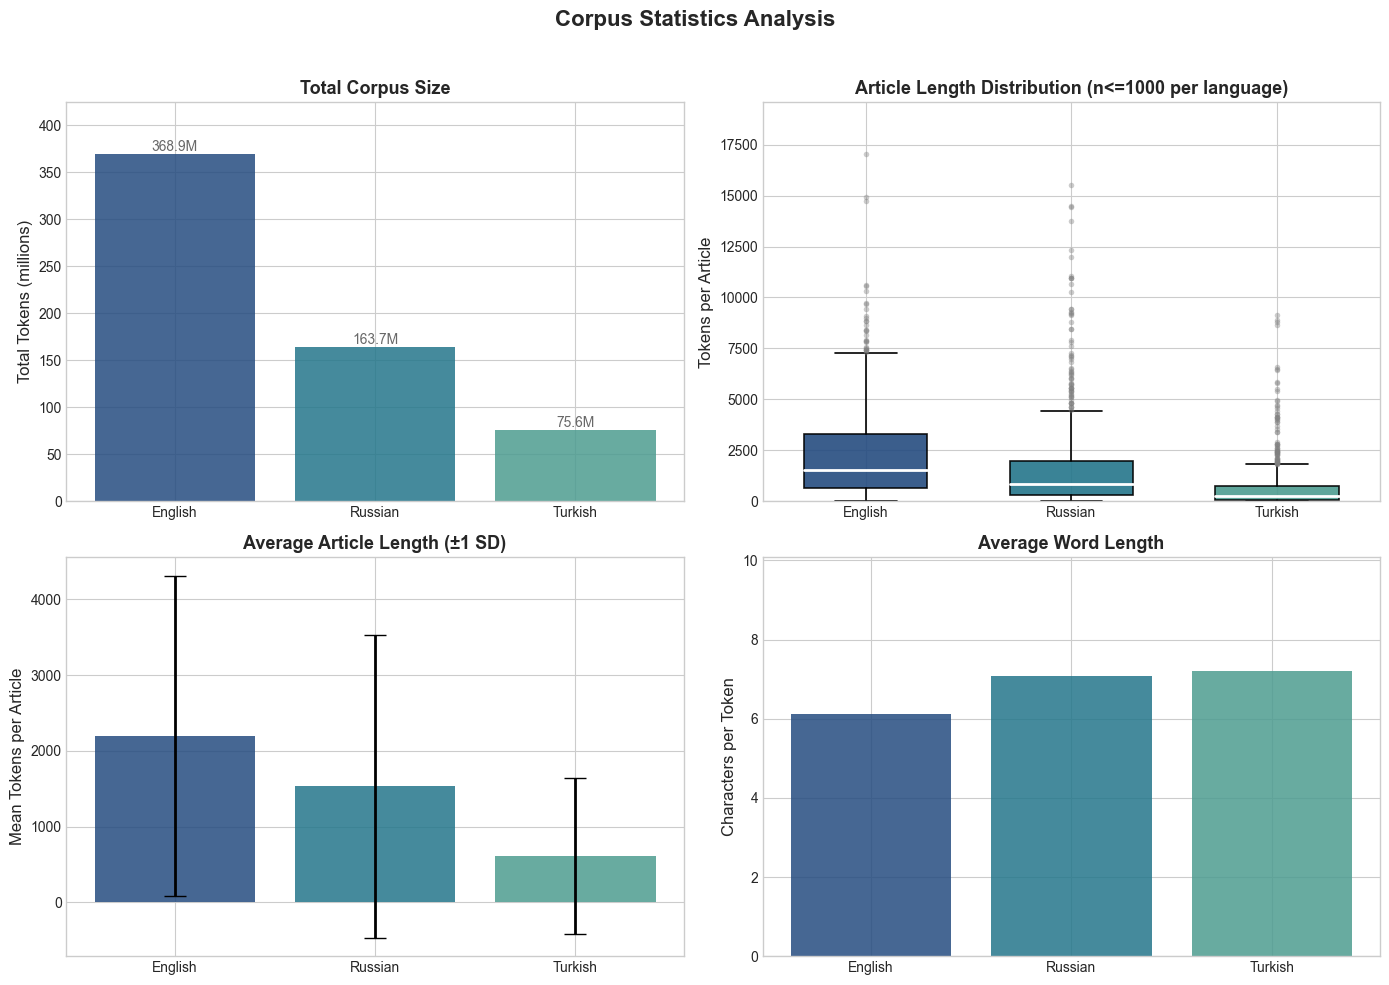

In [22]:
save_path = "corpus_statistics.png"

languages = list(stats.keys())
cmap = sns.color_palette("crest", as_cmap=True)
colors = [cmap(x) for x in np.linspace(0.85, 0.35, len(languages))]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Corpus Statistics Analysis', fontsize=16, fontweight='bold')

ax = axes[0, 0]
total_tokens = [stats[lang]['total_tokens'] for lang in languages]
total_tokens_m = [v / 1e6 for v in total_tokens]
bars = ax.bar(languages, total_tokens_m, color=colors, alpha=0.85)
ax.set_ylabel('Total Tokens (millions)', fontsize=12)
ax.set_title('Total Corpus Size', fontsize=13, fontweight='bold')
ax.set_ylim(0, max(total_tokens_m) * 1.15)
for bar, val_m in zip(bars, total_tokens_m):
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height(),
        f'{val_m:.1f}M',
        ha='center', va='bottom', fontsize=10, color='dimgrey'
    )

ax = axes[0, 1]
box_data = [stats[lang].get('tokens_per_article', []) for lang in languages]
bp = ax.boxplot(
    box_data, labels=languages, patch_artist=True, showfliers=True,
    flierprops=dict(marker='o', markersize=4, alpha=0.4, markeredgecolor='none', markerfacecolor='gray'),
    widths=0.6, medianprops={'color': 'white', 'linewidth': 2},
    boxprops={'linewidth': 1.2}, whiskerprops={'linewidth': 1.2}, capprops={'linewidth': 1.2}
)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.9)
ax.set_ylabel('Tokens per Article', fontsize=12)
ax.set_title(f'Article Length Distribution (n<={KEEP_FOR_PLOTS} per language)', fontsize=13, fontweight='bold')
flat = [v for lst in box_data for v in lst]
if flat:
    ax.set_ylim(0, max(flat) * 1.15)

ax = axes[1, 0]
means = [stats[lang]['mean_tokens_per_article'] for lang in languages]
stds  = [stats[lang]['std_tokens_per_article'] for lang in languages]
ax.bar(languages, means, yerr=stds, color=colors, alpha=0.85, capsize=8, error_kw={'elinewidth': 2})
ax.set_ylabel('Mean Tokens per Article', fontsize=12)
ax.set_title('Average Article Length (±1 SD)', fontsize=13, fontweight='bold')

ax = axes[1, 1]
chars_per_token = [stats[lang]['mean_chars_per_token'] for lang in languages]
ax.bar(languages, chars_per_token, color=colors, alpha=0.85)
ax.set_ylabel('Characters per Token', fontsize=12)
ax.set_title('Average Word Length', fontsize=13, fontweight='bold')
ax.set_ylim(0, max(chars_per_token) * 1.4)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

> With these visulaizations we can vividly see the complexity gradient English < Russian < Turkish we established before.

## Type-Token Ratio

TTR is going to be our first complexity measure. Languages with richer morphological systems generate more surface word forms from the same underlying vocabulary, which results in higher TTR.

We compute TTR across exactly **100,000 tokens** to eliminate sample size effects and isolate genuine morphological differences. The theoretical prediction is: **English** < **Russian** < **Turkish**, matching the complexity gradient we already assumed.

In [20]:
sample_size = 100_000
sample_points = [1_000, 5_000, 10_000, 25_000, 50_000, sample_size]
ttr_results = {}

for lang, filepath in CORPORA.items():
    
    all_tokens = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line_tokens = line.lower().split()
            all_tokens.extend(line_tokens)
    
    ttrs = []
    for n in sample_points:
        if n <= len(all_tokens):
            sample = random.sample(all_tokens, n)
            types = len(set(sample))
            ttrs.append(types / n)
        else:
            ttrs.append(None)
    
    final_idx = max(i for i, t in enumerate(ttrs) if t is not None) if any(t is not None for t in ttrs) else None
    final_ttr = ttrs[final_idx] if final_idx is not None else None
    
    if final_ttr is not None:
        final_n = sample_points[final_idx]
    
    ttr_results[lang] = {
        'sample_points': sample_points,
        'ttrs': ttrs,
        'final_ttr': final_ttr
    }

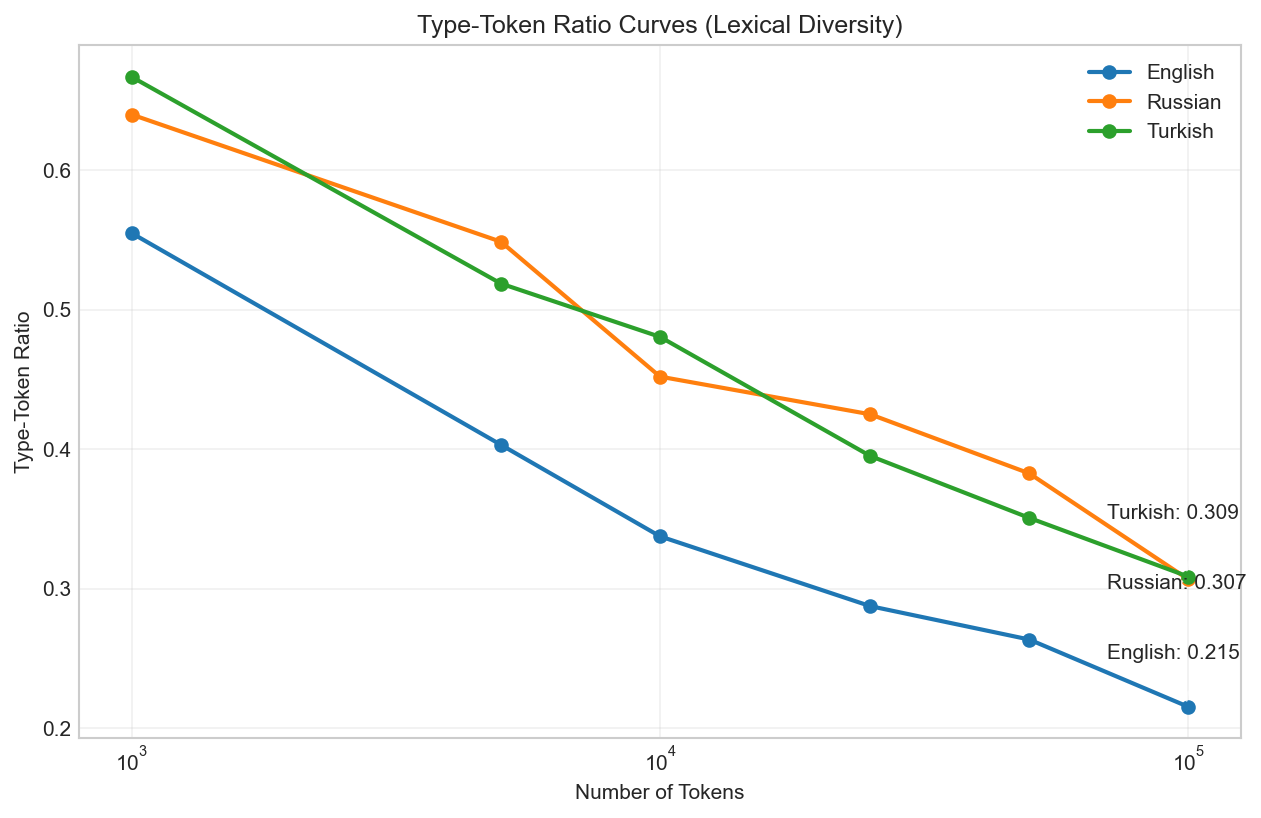

In [23]:
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for (lang, data), color in zip(ttr_results.items(), colors):
    valid_points = [(x, y) for x, y in zip(data['sample_points'], data['ttrs']) if y is not None]
    if not valid_points:
        continue
    x_vals, y_vals = zip(*valid_points)
    plt.plot(x_vals, y_vals, marker='o', label=lang, color=color, linewidth=2)

plt.xlabel('Number of Tokens')
plt.ylabel('Type-Token Ratio')
plt.title('Type-Token Ratio Curves (Lexical Diversity)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

annotation_positions = {
    'English': (sample_size * 0.7, 0.25),
    'Russian': (sample_size * 0.7, 0.30),
    'Turkish': (sample_size * 0.7, 0.35),
}

for lang, data in ttr_results.items():
    if data['final_ttr'] is not None:
        text_x, text_y = annotation_positions.get(lang, (sample_size * 0.5, data['final_ttr']))
        plt.annotate(f"{lang}: {data['final_ttr']:.3f}",
                     xy=(sample_size, data['final_ttr']),
                     xytext=(text_x, text_y),
                     fontsize=10,
                     arrowprops=dict(arrowstyle='->', alpha=0.5))

plt.show()

Results confirm our expectations:
- **Turkish**: TTR = 0.309 (highest morphological diversity)
- **Russian**: TTR = 0.307 (intermediate fusional complexity) 
- **English**: TTR = 0.215 (lowest analytic complexity)

Now let's look at all the stats we've got again

In [11]:
ttr_rows = {}
for lang, info in ttr_results.items():
    final_ttr = info['final_ttr']
    if final_ttr is not None:
        valid_idx = [i for i, v in enumerate(info['ttrs']) if v is not None]
        final_idx = valid_idx[-1]
        final_n = info['sample_points'][final_idx]
        final_types = int(final_ttr * final_n)
    else:
        final_n = None
        final_types = None

    ttr_rows[lang] = {
        "ttr_final": final_ttr,
        "ttr_final_n": final_n,
        "ttr_final_types": final_types,
    }

ttr_df = pd.DataFrame.from_dict(ttr_rows, orient="index")

summary_with_ttr_df = summary_df.join(ttr_df)
summary_with_ttr_df.to_csv(PHASE1_DIR / "summary_with_ttr.csv", index=True)

In [12]:
summary_with_ttr_df

,n_articles,total_tokens,total_chars,mean_tokens_per_article,std_tokens_per_article,median_tokens_per_article,mean_chars_per_token,ttr_final,ttr_final_n,ttr_final_types
English,350000.0,368910801.0,2.260091e+09,2202.611,2113.142347,1544.5,6.126389,0.21535,100000,21535
Russian,349988.0,163742644.0,1.157657e+09,1532.270,2003.942514,829.0,7.069980,0.30668,100000,30668
Turkish,349969.0,75577889.0,5.440182e+08,614.501,1028.868752,260.5,7.198114,0.30871,100000,30871


## Semantic Network Construction: Baseline Approach

After we validated morphological measures, we are going to construct semantic networks to establish baseline patterns before testing complexity trade-offs. We use *multilingual sentence embeddings* from the top 1,000 most frequent words per language, creating networks where edges represent semantic similarity above a **0.5 cosine threshold**.

This approach will give us some idea about semantic organization in the chosen langauges. However, as **Steyvers & Tenenbaum (2005)** demonstrate, realistic semantic networks show sparse, small-world properties with densities around **0.0001** and average degrees of **7-8**, very different from what we are about to see.

In [17]:
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

morph_measures = {
    'avg_chars_token': {'English': 6.13, 'Russian': 7.07, 'Turkish': 7.20},
    'ttr_100k': {'English': 0.215, 'Russian': 0.307, 'Turkish': 0.309}
}

# Set up and functions

In [13]:
N_TOP_WORDS = 1_000
SIM_THRESHOLD = 0.5
MAX_LINES = 200_000
MIN_LENGTH = 3

SEM_PHASE1_DIR = PHASE1_DIR / "semantic_baseline"
SEM_PHASE1_DIR.mkdir(parents=True, exist_ok=True)

In [17]:
def extract_top_words(filepath: Path, n_words=N_TOP_WORDS, min_length=MIN_LENGTH, max_lines=MAX_LINES):
    word_counts = Counter()
    print(f"Scanning {filepath.name} for top {n_words} words")
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_lines:
                break
            word_counts.update(w for w in line.lower().split() if len(w) >= min_length)
    top_words = [w for w, _ in word_counts.most_common(n_words)]
    print(f"Selected {len(top_words)} words.")
    return top_words

def build_threshold_network(words, embeddings, threshold=SIM_THRESHOLD):
    sim = cosine_similarity(embeddings)
    G = nx.Graph()
    G.add_nodes_from(words)
    n = len(words)
    for i in range(n):
        for j in range(i + 1, n):
            if sim[i, j] > threshold:
                G.add_edge(words[i], words[j])
    return G

def compute_network_metrics(G: nx.Graph):
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G) if n_nodes > 1 else 0.0
    avg_degree = (sum(dict(G.degree()).values()) / n_nodes) if n_nodes else 0.0
    clustering = nx.average_clustering(G) if n_nodes else 0.0
    return {
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "density": density,
        "avg_degree": avg_degree,
        "avg_clustering": clustering,
    }

In [18]:
semantic_results = {}
semantic_networks = {}

for lang, filepath in CORPORA.items():
    print(f"\nProcessing {lang}")
    words = extract_top_words(filepath)
    embeddings = embedder.encode(words, show_progress_bar=True)
    G = build_threshold_network(words, embeddings)
    metrics = compute_network_metrics(G)
    semantic_results[lang] = {"metrics": metrics, "n_top_words": len(words)}
    semantic_networks[lang] = G

    print(f"{lang} metrics:", metrics)

    (SEM_PHASE1_DIR / f"{lang.lower()}_top{N_TOP_WORDS}.txt").write_text("\n".join(words), encoding="utf-8")
    with open(SEM_PHASE1_DIR / f"{lang.lower()}_top{N_TOP_WORDS}_embeddings.pkl", "wb") as f:
        pickle.dump({"words": words, "embeddings": embeddings}, f)
    nx.write_edgelist(G, SEM_PHASE1_DIR / f"{lang.lower()}_threshold_{SIM_THRESHOLD:.2f}.edgelist", data=False)


Processing English
Scanning english_clean.txt for top 1000 words
Selected 1000 words.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

English metrics: {'n_nodes': 1000, 'n_edges': 74226, 'density': 0.1486006006006006, 'avg_degree': 148.452, 'avg_clustering': 0.644113337555178}

Processing Russian
Scanning russian_clean.txt for top 1000 words
Selected 1000 words.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Russian metrics: {'n_nodes': 1000, 'n_edges': 354483, 'density': 0.7096756756756757, 'avg_degree': 708.966, 'avg_clustering': 0.9015682348605273}

Processing Turkish
Scanning turkish_clean.txt for top 1000 words
Selected 1000 words.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Turkish metrics: {'n_nodes': 1000, 'n_edges': 345286, 'density': 0.6912632632632633, 'avg_degree': 690.572, 'avg_clustering': 0.8999264024838612}


In [19]:
semantic_metrics_df = pd.DataFrame({
    lang: res["metrics"] for lang, res in semantic_results.items()
}).T

In [20]:
semantic_metrics_df

,n_nodes,n_edges,density,avg_degree,avg_clustering
English,1000.0,74226.0,0.148601,148.452,0.644113
Russian,1000.0,354483.0,0.709676,708.966,0.901568
Turkish,1000.0,345286.0,0.691263,690.572,0.899926


In [21]:
semantic_metrics_path = SEM_PHASE1_DIR / "semantic_baseline_metrics.csv"
semantic_metrics_df.to_csv(semantic_metrics_path, index=True)

summary_with_semantic_df = summary_df.join(semantic_metrics_df, how="left")
summary_with_semantic_df.to_csv(PHASE1_DIR / "summary_with_ttr_and_semantic_baseline.csv", index=True)

summary_with_semantic_df

,n_articles,total_tokens,total_chars,mean_tokens_per_article,std_tokens_per_article,median_tokens_per_article,mean_chars_per_token,n_nodes,n_edges,density,avg_degree,avg_clustering
English,350000.0,368910801.0,2.260091e+09,2202.611,2113.142347,1544.5,6.126389,1000.0,74226.0,0.148601,148.452,0.644113
Russian,349988.0,163742644.0,1.157657e+09,1532.270,2003.942514,829.0,7.069980,1000.0,354483.0,0.709676,708.966,0.901568
Turkish,349969.0,75577889.0,5.440182e+08,614.501,1028.868752,260.5,7.198114,1000.0,345286.0,0.691263,690.572,0.899926


## Baseline Results: Methodological Insights

Like we assumed above, using a **0.5 similarity threshold** produced some unrealistically dense networks:

- **English**: density = 0.148601, average degree = 148.452
- **Russian**: density = 0.709676, average degree = 708.966
- **Turkish**: density = 0.691263, average degree = 690.572

These networks are essentially, fully connected graphs which is notwhere near how semantic structures should look. **Russian** and **Turkish** show near-identical clustering of 0.90, so we will have to refine our analysis later.

> Indeed, if we compare that to the established semantic networks like **WordNet** (which have density ~0.0001, degrees 7-8) we can tell that our threshold approach fails to capture the actual semantic patterns.

After we saw how this simple approach failed, we will try the **kNN** in Stage 2 and see how the results change.